In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.686527 -0.042237  0.631973  0.017999  0.098895  0.718111 -0.652673   
  1   0.718483 -0.908184  0.096774 -0.344951 -0.447061 -0.394751  0.798679   
  2   0.383763  0.301853  0.037798 -0.191587 -0.222762 -0.944122 -0.049959   
  3   0.006018  1.492523  0.982228  1.095628  0.273690  0.688394  0.613776   
  4   0.329430  0.397551 -0.230523  0.199202  0.466601  1.547340 -1.056190   
  5  -0.759095 -0.809533 -0.514894 -0.422792 -1.268045 -0.416890 -0.620964   
  6   0.041549  0.553305 -0.301991 -0.419527 -0.756634  0.209845  0.720463   
  7   0.554012  1.257757  0.272217  0.024626 -0.402700  0.848266  0.524099   
  8  -0.111713  0.783084  0.644103 -0.640964 -0.540800 -0.009628 -0.194958   
  9   0.356121 -0.271922  0.239984  0.478614 -0.400046 -0.989544 -0.832789   
  10  0.327709 -0.344558 -0.303619  0.492548  0.018343  0.101279 -0.553633   
  11  0.401093 -0.060645  0.435391  0.897111  0.672811  0.517418 -0.328175   
  12  0.277480  0.191720  0.431348 -0.686724 -0.118603 -1.037043 -0.412097   
  13  0.230641 -0.286280 -0.690435 -0.387109  0.953675  0.931299 -0.262019   
  14  0.554163  1.149862  1.030387 -0.078738 -0.600280  0.086079  0.081073   
  15  0.895584  0.550140 -0.353933  0.454665 -0.569184 -0.506505 -0.259054   
  16  0.725673  0.824636 -0.354561 -1.274714 -0.277519 -0.300838 -1.182054   
  17  1.132010  0.703542  0.714489  0.641337  0.191180 -0.246408  0.498358   
  18 -0.100964  0.703075  0.737484  0.614103 -0.160012  0.337921 -0.664915   
  19  0.962459  0.149233 -0.592787  0.480749 -0.174912  0.440273 -0.316734   
  20  1.407714  0.286093  0.799459 -0.809846 -0.146001  0.866620 -0.923116   
  21  1.092496  0.117336  0.041530 -0.306088 -0.601768  1.083803 -0.253192   
  22  0.715296  0.738576  0.102730  0.458610 -0.316699 -0.491213 -1.105424   
  23  1.581038  0.930601  0.210119 -0.865154 -0.452700 -0.298742 -0.854538   
  24  0.520590  0.955461 -0.501088  0.395015  0.209280 -0.587324 -0.272492   
1 0   0.537437  0.017854  0.800137 -0.040917  0.574354  0.718549  0.541048   
  1   1.422172 -0.032789  1.402907  1.288928  1.026068 -0.144833 -0.285166   
  2   0.534015  0.637133  1.245566 -0.127881 -0.959071 -0.521545  0.593130   
  3   0.540546  1.086131  1.020955 -0.862616  0.092325 -0.072518  0.140499   
  4  -0.363053  0.496148  0.255009  0.799246 -0.074344 -0.505734 -0.296590   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.123889 -0.160271  0.810465  ...  0.775933  0.122937 -0.847037   
  1  -1.287098 -0.006857  1.113150  ... -0.445008 -1.044419 -0.722669   
  2   0.355943 -0.722588 -0.289007  ...  0.010804  0.209377 -0.702426   
  3  -0.981439  0.170742  0.754026  ... -0.047003 -0.532438  0.251674   
  4  -1.629881 -0.403795  0.364848  ... -0.308201  0.133426  0.731187   
  5  -0.426179  0.055183  0.900317  ...  0.120447  0.408734 -0.039573   
  6  -0.668062 -0.473523  0.127561  ...  0.349046 -0.629751 -0.807532   
  7  -1.167030 -0.406379  0.321571  ... -0.239348 -0.713460 -0.063753   
  8  -0.439338  1.506697  0.491545  ... -0.607985 -0.466352 -1.626359   
  9  -1.398345  0.443920  0.213612  ...  0.689394  0.469034  0.387172   
  10 -0.051940  0.091992  0.321023  ...  0.502520  0.375011  0.086888   
  11  0.391320 -0.389610  0.315242  ... -0.154390 -0.817098 -1.009472   
  12 -1.103301  0.408862  0.809032  ...  0.907721 -0.289389  0.216176   
  13 -0.350235 -0.350170  0.363426  ...  0.162998 -1.229939 -0.556795   
  14 -1.294290 -0.415838  0.053648  ...  0.136589 -0.557523 -0.324648   
  15 -0.414923  0.692791  0.699940  ... -0.587214 -0.781396  0.559262   
  16 -0.639868  0.553357 -0.837235  ... -0.002539 -0.767562 -0.714752   
  17 -0.881486  1.055911  1.116282  ...  0.676796 -0.554464 -0.398103   
  18  0.169605  0.615409 -0.052514  ...  0.356509 -0.755002  0.409682   
  19 -0.847037 -0.334414  0.633235  ...  0.419022 -0.557483 -1.366075   
  20 -0.344437  0.230230  0.378062  ... -0.023334 -0.543896 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

      coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.03213  0.038779  26.615522  4.488775e-156  0.956124  1.108136


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



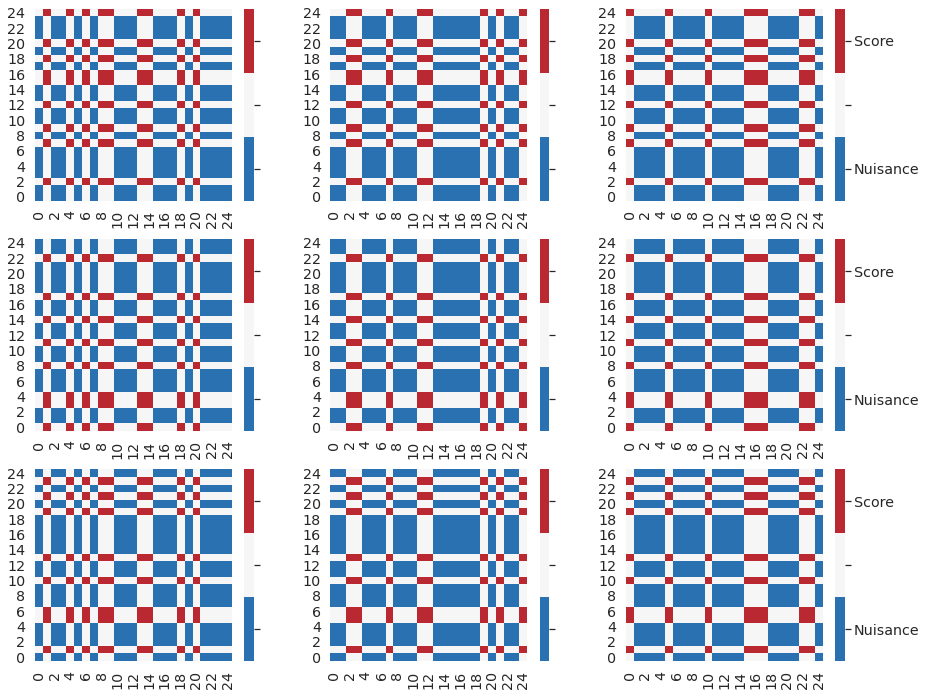

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



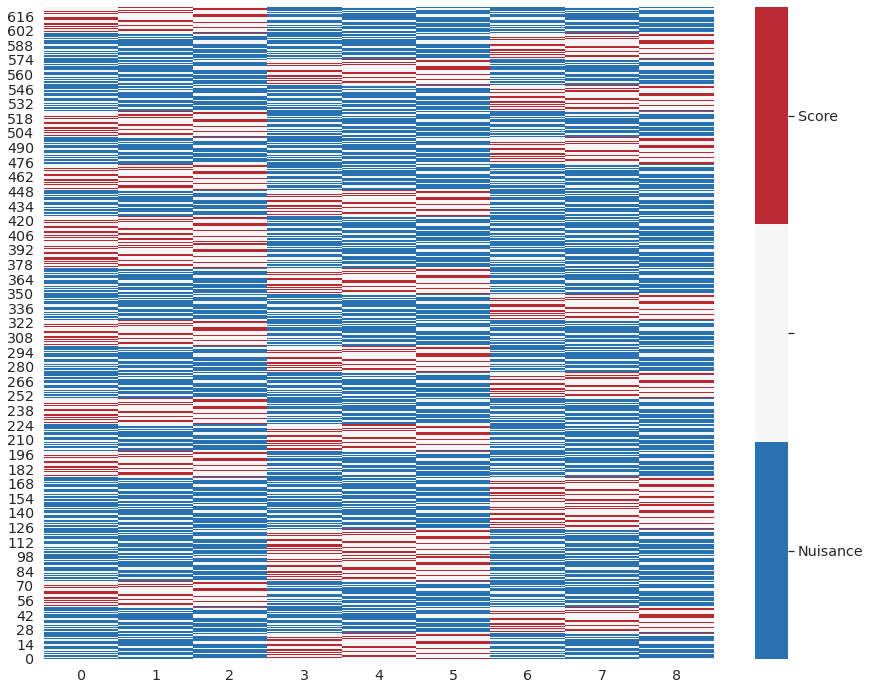

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])